# Data Source
* [Famine](https://web.archive.org/web/20170802193952/http://fletcher.tufts.edu/World-Peace-Foundation/Program/Research/Mass-Atrocities-Research-Program/Mass-Famine#Dataset)

# Data Preparation

In [2]:
# Get all necessary packages
import pandas as pd
import os
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Read in and check file
famine = pd.read_csv("data" + os.sep + "famine" + os.sep + "famine.csv", sep = ",")
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,NaN,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,NaN,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,NaN,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,NaN,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,NaN,India,"Drought, colonialism",6m,6000000,NaN,"Davis, 2002"
3,1876-79,1876,1876,NaN,Brazil,"Drought, economic crisis",500000,500000,NaN,"Cunniff, 1970"
4,1885-99,1885,1899,NaN,Congo,"Colonialism, forced labor",3m,3000000,NaN,"Hochschild, 1998; Acherson 1999"


In [4]:
# Calculate duration 
# Add one to avoid duration of 0
famine["Duration"] = (famine["End Year"]+1) - famine["Start Year"]
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,2,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,NaN,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,4,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,NaN,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,10,India,"Drought, colonialism",6m,6000000,NaN,"Davis, 2002"
3,1876-79,1876,1876,1,Brazil,"Drought, economic crisis",500000,500000,NaN,"Cunniff, 1970"
4,1885-99,1885,1899,15,Congo,"Colonialism, forced labor",3m,3000000,NaN,"Hochschild, 1998; Acherson 1999"


In [5]:
# Calculate death per year
famine["Death per Year"] = famine["Mean Death"] / famine["Duration"]
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,2,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,500000.0,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,4,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,2250000.0,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,10,India,"Drought, colonialism",6m,6000000,600000.0,"Davis, 2002"
3,1876-79,1876,1876,1,Brazil,"Drought, economic crisis",500000,500000,500000.0,"Cunniff, 1970"
4,1885-99,1885,1899,15,Congo,"Colonialism, forced labor",3m,3000000,200000.0,"Hochschild, 1998; Acherson 1999"


Text(0.5, 0, 'Death per year')

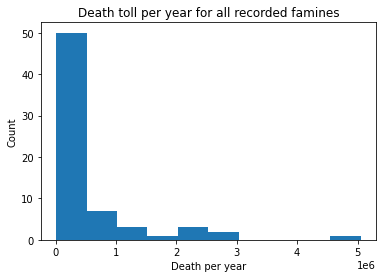

In [6]:
# Plot death per year
ax = famine["Death per Year"].sort_values(ascending=False).plot(kind="hist", bins= 10)
ax.set_title("Death toll per year for all recorded famines")
ax.set_ylabel("Count")
ax.set_xlabel("Death per year")

# Prepare for fitting

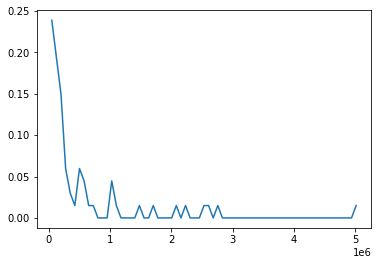

In [7]:
# Bin the data
density, death_per_year = np.histogram(famine["Death per Year"], bins = len(famine.index), density=True)
# adjust the denisty to the bin width (https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1)
density = density*np.diff(death_per_year)
# calculate the bin means
death_per_year = np.array([0.5 * (death_per_year[i] + death_per_year[i+1]) for i in range(len(death_per_year)-1)])
# plot
plt.plot(death_per_year, density)

# Histogram fit to Power Law

In [8]:
# Fit data to power law
def powerlaw(x,exponent):
    return (x**exponent)/np.min(x)**exponent
params, covar = curve_fit(powerlaw, death_per_year, density)
params

array([-1.57879647])

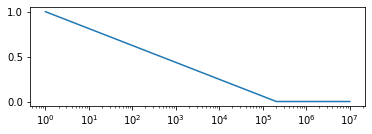

In [9]:
# Plot the power law
x_sim = np.linspace(1,10000000)
y_sim = powerlaw(x_sim, params[0])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim)
ax.set_xscale("log")

In [10]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000])
probs = powerlaw([amount_dead],params[0])
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[0][i]))

Dead: 1
Prob of this many dead: 1.0
Dead: 10
Prob of this many dead: 0.02637567197512913
Dead: 100
Prob of this many dead: 0.0006956760721396122
Dead: 1000
Prob of this many dead: 1.834892387970068e-05
Dead: 10000
Prob of this many dead: 4.839651973475989e-07
Dead: 100000
Prob of this many dead: 1.2764907292618904e-08
Dead: 1000000
Prob of this many dead: 3.366830075430499e-10
Dead: 10000000
Prob of this many dead: 8.880240566555412e-12
Dead: 100000000
Prob of this many dead: 2.342223122437004e-13


# Histogram fit to lognormal

In [11]:
# Fit data to lognormal
def lognormal(x,upsilon,epsilon):
    numerator=np.exp(-np.power((np.log(x)-upsilon),2)/(2*epsilon**2))
    denominator=x*np.sqrt(2*np.pi*epsilon**2)
    return numerator/denominator
params, covar = curve_fit(lognormal, death_per_year, density)
params

array([1., 1.])

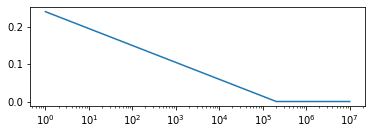

In [12]:
# Plot the lognormal
x_sim = np.linspace(1,10000000)
y_sim = lognormal(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim)
ax.set_xscale("log")

In [13]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000])
probs = [lognormal(i,params[0], params[1]) for i in amount_dead]
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[i]))

Dead: 1
Prob of this many dead: 0.24197072451914337
Dead: 10
Prob of this many dead: 0.01707930831120357
Dead: 100
Prob of this many dead: 6.006101107306473e-06
Dead: 1000
Prob of this many dead: 1.0522765842835267e-11
Dead: 10000
Prob of this many dead: 9.185061761818969e-20
Dead: 100000
Prob of this many dead: 3.994378012615924e-30
Dead: 1000000
Prob of this many dead: 8.654284159840767e-43
Dead: 10000000
Prob of this many dead: 9.341745823045648e-58
Dead: 100000000
Prob of this many dead: 5.023886845089719e-75


# Cumulative distribution fitting with power law

In [14]:
# Sort for further calculations with cumsum
famine=famine.sort_values("Death per Year",ascending=False)

Text(0.5, 1.0, 'Probability if a given famine will reach a certain death level?')

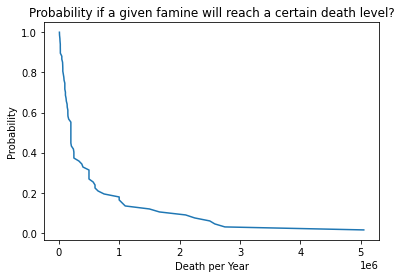

In [39]:
# Calculate the probability in a year with a given famine
# Does it make more sense to take the whole timeline with 141 years?
years_with_famine = 67
famine["time"] = 1/years_with_famine
famine["cs_time"] = np.cumsum(famine["time"])
# Plot
fig = plt.Figure()
plt.plot(famine["Death per Year"], famine["cs_time"])
ax = plt.gca()
ax.set_xlabel("Death per Year")
ax.set_ylabel("Probability")
ax.set_title("Probability if a given famine will reach a certain death level?")

In [16]:
# Fit data to power law
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
# Provide values for the parameters to avoid them becoming to negative?
params, covar = curve_fit(func_powerlaw, famine["Death per Year"], famine["cs_time"], maxfev=100000)
params

array([ 1.53162714e-04, -1.31797139e+03,  1.32095718e+03])

(0.0, 1.0)

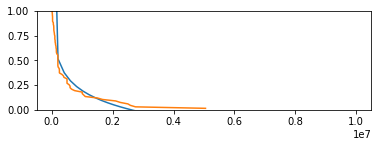

In [17]:
# Plot the power law
x_sim = np.linspace(1,10000000)
y_sim = func_powerlaw(x_sim, params[0], params[1], params[2])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(famine["Death per Year"], famine["cs_time"], label="real")
ax.set_ylim([0,1])
#ax.set_xscale("log")

In [41]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])
probs = func_powerlaw(x_sim, params[0], params[1], params[2])
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[i]))

Dead: 1
Prob of this many dead: 0.43577832463961386
Dead: 10
Prob of this many dead: 0.36433796669916774
Dead: 100
Prob of this many dead: 0.293615954091365
Dead: 1000
Prob of this many dead: 0.22359798766228778
Dead: 10000
Prob of this many dead: 0.15427019097842276
Dead: 100000
Prob of this many dead: 0.08561909381933219
Dead: 1000000
Prob of this many dead: 0.017631616479775403
Dead: 10000000
Prob of this many dead: -0.04970494518602209
Dead: 100000000
Prob of this many dead: -0.11640293399432267
Dead: 1000000000
Prob of this many dead: -0.18247434501245152


# Cumulative distribution fitting with lognormal

In [19]:
# Fit data to lognormal
def lognormal(x,upsilon,epsilon):
    numerator=np.exp(-np.power((np.log(x)-upsilon),2)/(2*epsilon**2))
    denominator=x*np.sqrt(2*np.pi*epsilon**2)
    return numerator/denominator
params, covar = curve_fit(lognormal, famine["Death per Year"], famine["cs_time"])
params

/home/florian/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([1., 1.])

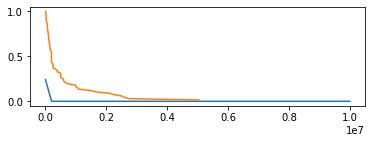

In [20]:
# Plot the lognormal
x_sim = np.linspace(1,10000000)
y_sim = lognormal(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(famine["Death per Year"], famine["cs_time"], label="real")
#ax.set_xscale("log")

In [21]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])
probs = lognormal(x_sim, params[0], params[1])
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[i]))

Dead: 1
Prob of this many dead: 0.24197072451914337
Dead: 10
Prob of this many dead: 8.397982015811593e-34
Dead: 100
Prob of this many dead: 1.3784232157222573e-37
Dead: 1000
Prob of this many dead: 6.740468450610778e-40
Dead: 10000
Prob of this many dead: 1.3993500189074077e-41
Dead: 100000
Prob of this many dead: 6.545170900083819e-43
Dead: 1000000
Prob of this many dead: 5.1662411604011995e-44
Dead: 10000000
Prob of this many dead: 5.882378565418778e-45
Dead: 100000000
Prob of this many dead: 8.78635965440304e-46
Dead: 1000000000
Prob of this many dead: 1.6181673056981614e-46


# Fitting cumulative distribution in loglog space

In [23]:
# Transform data in loglog space
log_death_rate = np.log(famine["Death per Year"])
log_cs_time = np.log(famine["cs_time"])

In [26]:
# Fit data to power law
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
# Provide values for the parameters to avoid them becoming to negative?
params, covar = curve_fit(func_powerlaw, log_death_rate, log_cs_time, maxfev=100000)
params

array([-4.75421089e-04,  1.48174731e+04, -1.48008256e+04])

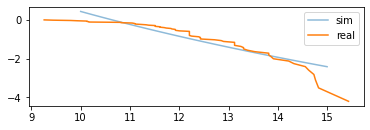

In [38]:
# Plot the power law
x_sim = np.linspace(10,15)
y_sim = func_powerlaw(x_sim, params[0], params[1], params[2])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim",alpha=0.5)
ax.plot(log_death_rate, log_cs_time, label="real")
ax.legend()
#ax.set_ylim([0,1])
#ax.set_xscale("log")
